# HW2 Experiment Analysis

Plots learning curves (average return vs. environment steps) for the 8 CartPole policy-gradient experiments from `exp1.sh`.

In [3]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd

SMALL_BATCH_EXPS = [
    "cartpole",
    "cartpole_rtg",
    "cartpole_na",
    "cartpole_rtg_na",
]

LARGE_BATCH_EXPS = [
    "cartpole_lb",
    "cartpole_lb_rtg",
    "cartpole_lb_na",
    "cartpole_lb_rtg_na",
]

CHEETAH_EXPS = [
    "cheetah",
    "cheetah_baseline",
]

CHEETAH_BASELINE_VARIANTS = [
    "cheetah_baseline",
    "cheetah_baseline_bgs2",
    "cheetah_baseline_blr001",
]

LUNAR_LANDER_EXPS = [
    "lunar_lander_lambda0",
    "lunar_lander_lambda0.95",
    "lunar_lander_lambda0.98",
    "lunar_lander_lambda0.99",
    "lunar_lander_lambda1",
]

RUN_DIR_TS_RE = re.compile(r"_sd(?P<seed>\d+)_(?P<ts>\d{8}_\d{6})$")


def find_exp_root() -> Path:
    """Find the repo-level exp directory from common notebook working dirs."""
    cwd = Path.cwd().resolve()
    candidates = []
    for base in [cwd, *cwd.parents]:
        c = base / "exp"
        if c not in candidates:
            candidates.append(c)
    for c in candidates:
        if c.is_dir():
            return c
    raise FileNotFoundError(
        "Could not find an 'exp' directory. Run experiment scripts first, or set EXP_ROOT manually."
    )


EXP_ROOT = find_exp_root()
print(f"Using experiment root: {EXP_ROOT}")


def latest_log_for_exp(exp_name: str, exp_root: Path = EXP_ROOT) -> Path:
    matches = []
    token = f"_{exp_name}_sd"

    for run_dir in exp_root.iterdir():
        if not run_dir.is_dir():
            continue
        if token not in run_dir.name:
            continue
        m = RUN_DIR_TS_RE.search(run_dir.name)
        if not m:
            continue
        log_path = run_dir / "log.csv"
        if not log_path.exists():
            continue
        matches.append((m.group("ts"), log_path))

    if not matches:
        raise FileNotFoundError(
            f"No matching log.csv found for experiment '{exp_name}' under {exp_root}"
        )

    matches.sort(key=lambda x: x[0])
    return matches[-1][1]


def load_curve(exp_name: str) -> pd.DataFrame:
    log_path = latest_log_for_exp(exp_name)
    df = pd.read_csv(log_path)

    required_cols = ["Train_EnvstepsSoFar", "Train_AverageReturn"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"{log_path} is missing columns: {missing}")

    curve = (
        df[required_cols]
        .dropna()
        .sort_values("Train_EnvstepsSoFar")
        .reset_index(drop=True)
    )
    print(f"{exp_name:18s} -> {log_path}")
    return curve


def load_metric(exp_name: str, y_col: str, x_col: str = "step") -> pd.DataFrame:
    log_path = latest_log_for_exp(exp_name)
    df = pd.read_csv(log_path)

    required_cols = [x_col, y_col]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"{log_path} is missing columns: {missing}")

    metric = (
        df[required_cols]
        .dropna()
        .sort_values(x_col)
        .reset_index(drop=True)
    )
    print(f"{exp_name:18s} -> {log_path}")
    return metric


def plot_group(exp_names, title):
    plt.figure(figsize=(8, 5))
    for exp_name in exp_names:
        curve = load_curve(exp_name)
        plt.plot(
            curve["Train_EnvstepsSoFar"],
            curve["Train_AverageReturn"],
            label=exp_name,
            linewidth=2,
        )

    plt.xlabel("Environment Steps")
    plt.ylabel("Average Return")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_metric(exp_names, y_col, title, x_col="step"):
    plt.figure(figsize=(8, 5))
    for exp_name in exp_names:
        metric = load_metric(exp_name, y_col=y_col, x_col=x_col)
        plt.plot(metric[x_col], metric[y_col], label=exp_name, linewidth=2)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


Using experiment root: /home/seoyeon/cs285/homework_spring2026/hw2/exp


cartpole           -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_sd1_20260225_184148/log.csv
cartpole_rtg       -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_rtg_sd1_20260225_184208/log.csv
cartpole_na        -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_na_sd1_20260225_184228/log.csv
cartpole_rtg_na    -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_rtg_na_sd1_20260225_184247/log.csv


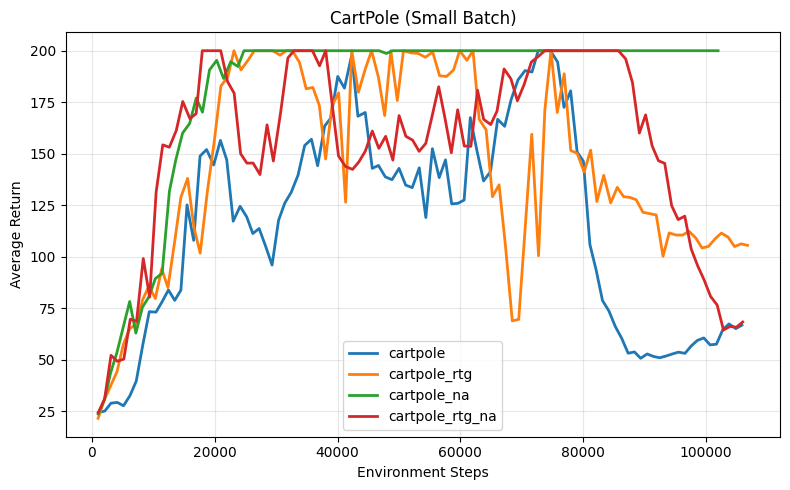

In [4]:
# Small batch experiments (prefixes without _lb)
plot_group(
    SMALL_BATCH_EXPS,
    "CartPole (Small Batch)",
)


cartpole_lb        -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_lb_sd1_20260225_184307/log.csv
cartpole_lb_rtg    -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_lb_rtg_sd1_20260225_184357/log.csv
cartpole_lb_na     -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_lb_na_sd1_20260225_184448/log.csv
cartpole_lb_rtg_na -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/CartPole-v0_cartpole_lb_rtg_na_sd1_20260225_184538/log.csv


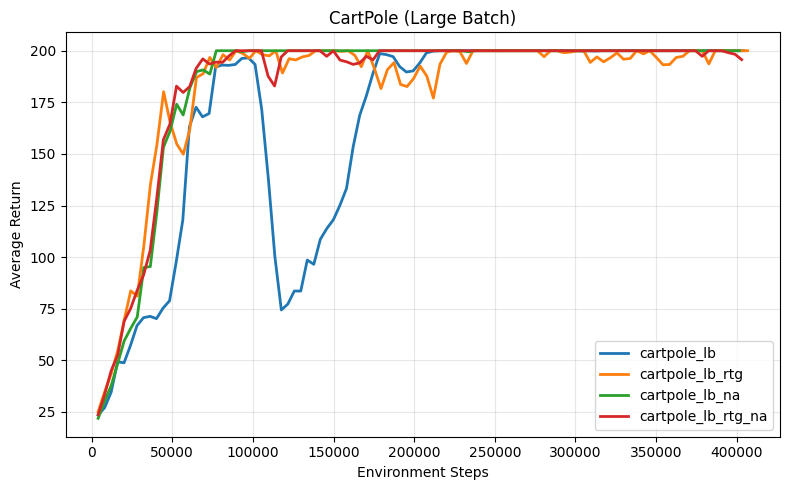

In [5]:
# Large batch experiments (prefixes with _lb)
plot_group(
    LARGE_BATCH_EXPS,
    "CartPole (Large Batch)",
)


cheetah_baseline   -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/HalfCheetah-v4_cheetah_baseline_sd1_20260225_190038/log.csv


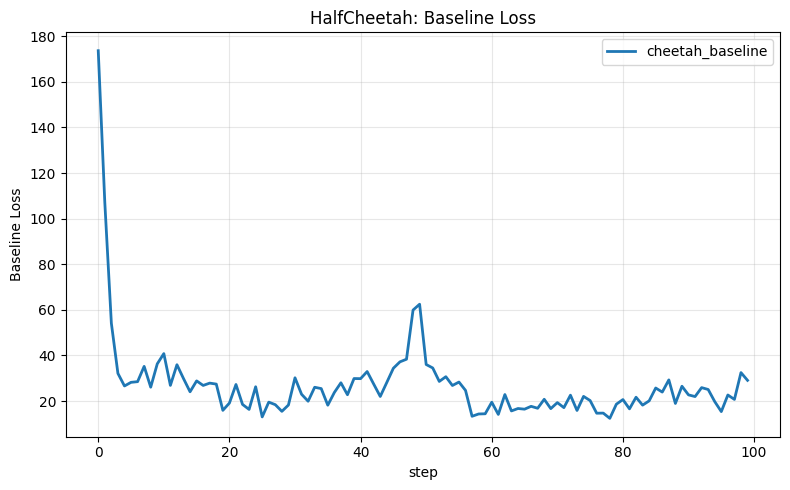

In [6]:
# exp2: baseline loss learning curve (baseline run only)
plot_metric(
    ["cheetah_baseline"],
    y_col="Baseline Loss",
    title="HalfCheetah: Baseline Loss",
    x_col="step",
)


cheetah            -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/HalfCheetah-v4_cheetah_sd1_20260225_185918/log.csv
cheetah_baseline   -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/HalfCheetah-v4_cheetah_baseline_sd1_20260225_190038/log.csv


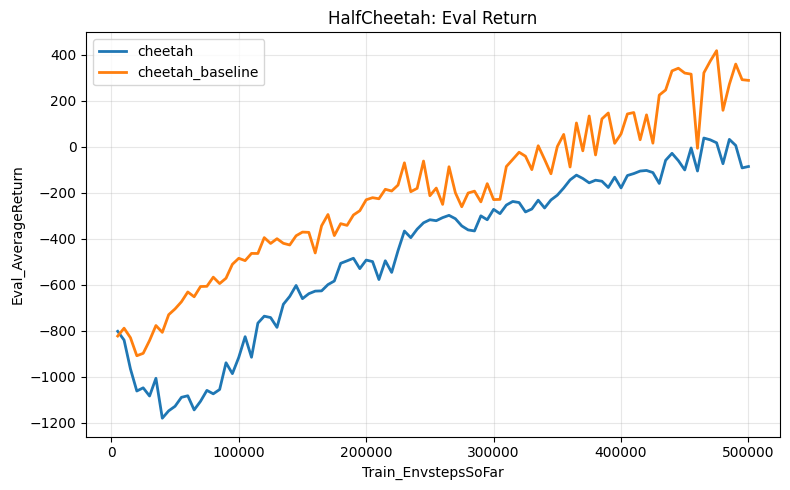

In [7]:
# exp2: eval return learning curve (compare no-baseline vs baseline)
plot_metric(
    CHEETAH_EXPS,
    y_col="Eval_AverageReturn",
    title="HalfCheetah: Eval Return",
    x_col="Train_EnvstepsSoFar",
)


cheetah_baseline   -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/HalfCheetah-v4_cheetah_baseline_sd1_20260225_190038/log.csv


FileNotFoundError: No matching log.csv found for experiment 'cheetah_baseline_bgs2' under /home/seoyeon/cs285/homework_spring2026/hw2/exp

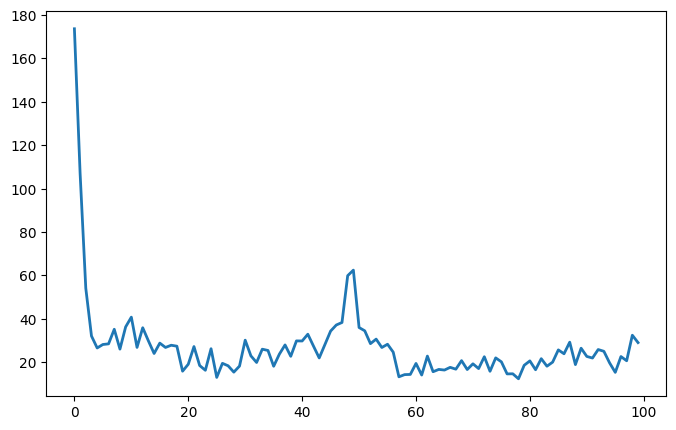

In [8]:
# exp2-2: effect on baseline learning curve (compare baseline variants)
plot_metric(
    CHEETAH_BASELINE_VARIANTS,
    y_col="Baseline Loss",
    title="HalfCheetah: Baseline Loss (baseline variants)",
    x_col="step",
)


cheetah_baseline   -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/HalfCheetah-v4_cheetah_baseline_sd1_20260225_190038/log.csv


FileNotFoundError: No matching log.csv found for experiment 'cheetah_baseline_bgs2' under /home/seoyeon/cs285/homework_spring2026/hw2/exp

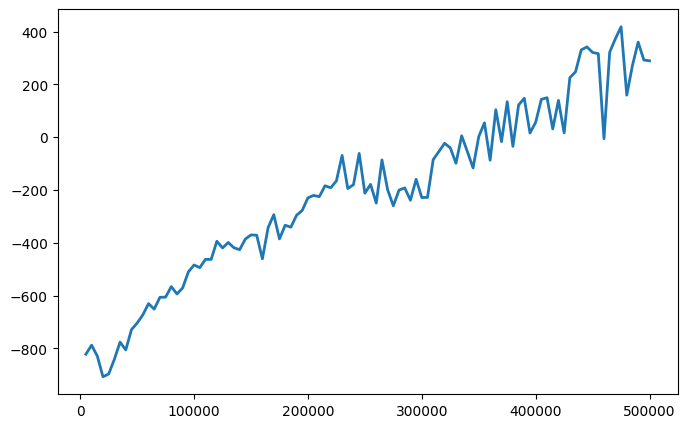

In [9]:
# exp2-2: effect on policy performance (compare baseline variants)
plot_metric(
    CHEETAH_BASELINE_VARIANTS,
    y_col="Eval_AverageReturn",
    title="HalfCheetah: Eval Return (baseline variants)",
    x_col="Train_EnvstepsSoFar",
)


lunar_lander_lambda0 -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/LunarLander-v2_lunar_lander_lambda0_sd1_20260225_190856/log.csv
lunar_lander_lambda0.95 -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/LunarLander-v2_lunar_lander_lambda0.95_sd1_20260225_191320/log.csv
lunar_lander_lambda0.98 -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/LunarLander-v2_lunar_lander_lambda0.98_sd1_20260225_192144/log.csv
lunar_lander_lambda0.99 -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/LunarLander-v2_lunar_lander_lambda0.99_sd1_20260225_192826/log.csv
lunar_lander_lambda1 -> /home/seoyeon/cs285/homework_spring2026/hw2/exp/LunarLander-v2_lunar_lander_lambda1_sd1_20260225_193401/log.csv


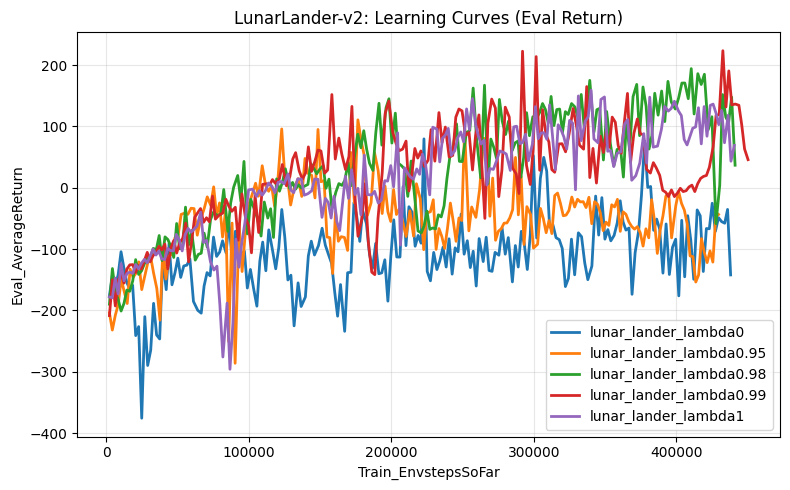

In [10]:
# exp3: LunarLander-v2 learning curves (single comparison plot)
plot_metric(
    LUNAR_LANDER_EXPS,
    y_col="Eval_AverageReturn",
    title="LunarLander-v2: Learning Curves (Eval Return)",
    x_col="Train_EnvstepsSoFar",
)


## Exp4: InvertedPendulum-v4

Compare average return vs. training environment steps for the `exp4.sh` hyperparameter candidates.


In [13]:
PENDULUM_EXPS = [
    "pendulum_gae097_b1000_lr3e3",
    "pendulum_b2000_lr2e3_gae095",
    "pendulum_b800_lr3e3_gae098",
    "pendulum_conservative_lr1e3",
    # "pendulum_no_gae_baseline",
    "pendulum"
]

# Exp4: primary comparison (eval average return vs env steps)
plot_metric(
    PENDULUM_EXPS,
    y_col="Eval_AverageReturn",
    title="InvertedPendulum-v4: Eval Average Return",
    x_col="Train_EnvstepsSoFar",
)


FileNotFoundError: No matching log.csv found for experiment 'pendulum_gae097_b1000_lr3e3' under /home/seoyeon/cs285/homework_spring2026/hw2/exp

<Figure size 800x500 with 0 Axes>

In [ ]:
# Exp4: train average return vs env steps (with target line at 1000)
plt.figure(figsize=(8, 5))
for exp_name in PENDULUM_EXPS:
    curve = load_curve(exp_name)
    plt.plot(curve["Train_EnvstepsSoFar"], curve["Train_AverageReturn"], label=exp_name, linewidth=2)

# plt.axhline(1000, color="black", linestyle="--", linewidth=1.5, label="target=1000")
plt.axvline(100000, color="black", linestyle="--", linewidth=1.5)
plt.xlim(0, 120000)
plt.xlabel("Environment Steps")
plt.ylabel("Train Average Return")
plt.title("InvertedPendulum-v4: Train Average Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


: 